У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek

In [96]:
df = pd.read_csv("customer_segmentation_train.csv")

In [97]:
raw_df  = df.copy()

In [98]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [169]:
raw_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


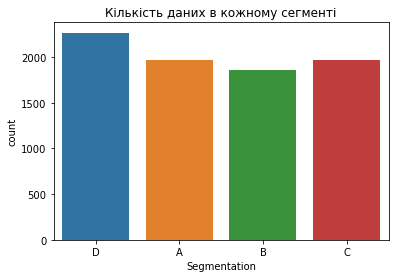

In [100]:
sns.countplot(x='Segmentation', data=raw_df)
plt.title('Кількість даних в кожному сегменті')
plt.show()

In [102]:
train_df, test_df = train_test_split(df_full_prep, test_size=0.2, random_state=42, stratify=raw_df['Segmentation'])

In [103]:
input_cols = list(df_full_prep.columns)[1:-1]
target_col = 'Segmentation'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

In [104]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()  
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['Age', 'Work_Experience', 'Family_Size'],
 ['Gender',
  'Ever_Married',
  'Graduated',
  'Profession',
  'Spending_Score',
  'Var_1'])

In [171]:
#подивимось на кількість пропущених даних в кожній колонці
raw_df.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [172]:
num_imputer = SimpleImputer(strategy='median')

In [106]:
train_inputs[numeric_cols] = num_imputer.fit_transform(train_inputs[numeric_cols])
test_inputs[numeric_cols] = num_imputer.transform(test_inputs[numeric_cols])  

In [174]:
#Подивимось чи залишились пропущені дані в числових колонках 
print(train_inputs[numeric_cols].isnull().sum().sum()) 
print(test_inputs[numeric_cols].isnull().sum().sum())  

0
0


In [108]:
cat_imputer = SimpleImputer(strategy='most_frequent')

In [109]:
train_inputs[categorical_cols] = cat_imputer.fit_transform(train_inputs[categorical_cols])
test_inputs[categorical_cols] = cat_imputer.transform(test_inputs[categorical_cols])  

In [175]:
#Подивимось чи залишились пропущені дані в категоріальних колонках 
print(train_inputs[categorical_cols].isnull().sum().sum()) 
print(test_inputs[categorical_cols].isnull().sum().sum())  

0
0


In [111]:
scaler = StandardScaler()

In [112]:
scaler.fit(train_inputs[numeric_cols])

StandardScaler()

In [113]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [114]:
train_inputs[numeric_cols].describe().round(2)

,Age,Work_Experience,Family_Size
count,6454.00,6454.00,6454.00
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-1.54,-0.76,-1.23
25%,-0.76,-0.76,-0.56
50%,-0.16,-0.46,0.10
75%,0.56,0.45,0.77
max,2.72,3.49,4.10


In [115]:
encoder = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

In [116]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(drop='first', sparse=False)

In [117]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Artist', 'Doctor', 'Engineer', 'Entertainment', 'Executive',
        'Healthcare', 'Homemaker', 'Lawyer', 'Marketing'], dtype=object),
 array(['Average', 'High', 'Low'], dtype=object),
 array(['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7'],
       dtype=object)]

In [118]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)

['Gender_Male', 'Ever_Married_Yes', 'Graduated_Yes', 'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment', 'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer', 'Profession_Marketing', 'Spending_Score_High', 'Spending_Score_Low', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7']


In [119]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [120]:
print(numeric_cols + encoded_cols)

['Age', 'Work_Experience', 'Family_Size', 'Gender_Male', 'Ever_Married_Yes', 'Graduated_Yes', 'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment', 'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer', 'Profession_Marketing', 'Spending_Score_High', 'Spending_Score_Low', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7']


In [122]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

<span style="color:green"> Застосування базового SMOTE лише на числових (НЕ категоріальних ознаках). </span> 

In [123]:
#Зробимо копії датафреймів тільки з числовими даними
train_inputs_num  = train_inputs[numeric_cols].copy()
test_inputs_num  = test_inputs[numeric_cols].copy() 

smote = SMOTE(random_state = 42) 

train_inputs_smote, train_targets_smote = smote.fit_resample(train_inputs_num, train_targets)

<AxesSubplot:>

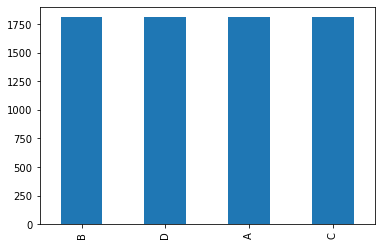

In [168]:
#подивимось чи вирівнялась кількість даних
train_targets_smote.value_counts().plot.bar()

<span style="color:green"> Застосування SMOTENC на числових  та категоріальних ознаках. </span> 

In [128]:
encoded_cols

['Gender_Male',
 'Ever_Married_Yes',
 'Graduated_Yes',
 'Profession_Doctor',
 'Profession_Engineer',
 'Profession_Entertainment',
 'Profession_Executive',
 'Profession_Healthcare',
 'Profession_Homemaker',
 'Profession_Lawyer',
 'Profession_Marketing',
 'Spending_Score_High',
 'Spending_Score_Low',
 'Var_1_Cat_2',
 'Var_1_Cat_3',
 'Var_1_Cat_4',
 'Var_1_Cat_5',
 'Var_1_Cat_6',
 'Var_1_Cat_7']

In [130]:
categorical_feature_indices = [X_train.columns.get_loc(col) for col in encoded_cols]

smotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state = 42) 

train_inputs_smotenc, train_targets_smotenc = smotenc.fit_resample(X_train, train_targets)

<span style="color:green"> Застосування SMOTETomek на спочатку тільки на трьох числових колонках, потім на всіх колонках. </span> 

In [148]:
smotetomek = SMOTETomek(random_state = 42) 
#ресамплінг тільки числових даних
train_inputs_smotetomek, train_targets_smotetomek = smotetomek.fit_resample(train_inputs_num, train_targets)

In [150]:
#ресамплінг всіх даних (числових та закодованих категоріальних)
train_inputs_smotetomek_all, train_targets_smotetomek_all = smotetomek.fit_resample(X_train, train_targets)

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [159]:
print("       === Логістична регресія на оригінальних даних ===")

log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)
ovr_model.fit(X_train, train_targets)
ovr_predictions = ovr_model.predict(X_test)

print(classification_report(test_targets, ovr_predictions))

       === Логістична регресія на оригінальних даних ===
              precision    recall  f1-score   support

           A       0.42      0.46      0.44       394
           B       0.41      0.17      0.24       372
           C       0.49      0.62      0.55       394
           D       0.65      0.75      0.70       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614



In [160]:
print("                   === Логістична регресія з SMOTE ===")

log_reg_smote = LogisticRegression(solver='liblinear')
ovr_model_smote = OneVsRestClassifier(log_reg_smote)
ovr_model_smote.fit(train_inputs_smote, train_targets_smote)
ovr_predictions_smote = ovr_model_smote.predict(test_inputs_num)

print(classification_report(test_targets, ovr_predictions_smote))

                   === Логістична регресія з SMOTE ===
              precision    recall  f1-score   support

           A       0.33      0.27      0.29       394
           B       0.26      0.10      0.15       372
           C       0.37      0.43      0.39       394
           D       0.50      0.76      0.60       454

    accuracy                           0.41      1614
   macro avg       0.36      0.39      0.36      1614
weighted avg       0.37      0.41      0.37      1614



In [165]:
print("                   === Логістична регресія з SMOTENC ===")

log_reg_smotenc = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg_smotenc)
ovr_model.fit(train_inputs_smotenc, train_targets_smotenc)
ovr_predictions_smotenc = ovr_model.predict(X_test)

print(classification_report(test_targets, ovr_predictions_smotenc))

                   === Логістична регресія з SMOTENC ===
              precision    recall  f1-score   support

           A       0.43      0.48      0.45       394
           B       0.42      0.26      0.32       372
           C       0.52      0.59      0.55       394
           D       0.67      0.72      0.70       454

    accuracy                           0.53      1614
   macro avg       0.51      0.51      0.51      1614
weighted avg       0.52      0.53      0.52      1614



In [166]:
print("=== Логістична регресія з SMOTETOMEK тільки на числових даних ===")

log_reg_smotetomek = LogisticRegression(solver='liblinear')
ovr_model_smotetomek = OneVsRestClassifier(log_reg_smotetomek)
ovr_model_smotetomek.fit(train_inputs_smotetomek, train_targets_smotetomek)
ovr_predictions_smotetomek = ovr_model_smotetomek.predict(test_inputs_num)

print(classification_report(test_targets, ovr_predictions_smotetomek))

=== Логістична регресія з SMOTETOMEK тільки на числових даних ===
              precision    recall  f1-score   support

           A       0.34      0.28      0.31       394
           B       0.29      0.10      0.15       372
           C       0.37      0.43      0.40       394
           D       0.50      0.75      0.60       454

    accuracy                           0.41      1614
   macro avg       0.37      0.39      0.36      1614
weighted avg       0.38      0.41      0.38      1614



In [163]:
print("=== Логістична регресія з SMOTETOMEK на числових та закодованих категоріальних даних ===")

log_reg_smotetomek_all = LogisticRegression(solver='liblinear')
ovr_model_smotetomek_all = OneVsRestClassifier(log_reg_smotetomek_all)
ovr_model_smotetomek_all.fit(train_inputs_smotetomek_all, train_targets_smotetomek_all)
ovr_predictions_smotetomek_all = ovr_model_smotetomek_all.predict(X_test)

print(classification_report(test_targets, ovr_predictions_smotetomek_all))

=== Логістична регресія з SMOTETOMEK на числових та закодованих категоріальних даних ===
              precision    recall  f1-score   support

           A       0.42      0.49      0.46       394
           B       0.39      0.23      0.29       372
           C       0.50      0.59      0.54       394
           D       0.68      0.70      0.69       454

    accuracy                           0.52      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.51      0.52      0.50      1614



<span style="color:green">  В цьому випадку варто вибрати метрику macro avg f1-score для порівняння результатів, оскільки вона враховує незбалансованість класів та збалансовано враховує як prcision так і recall. Найкращі результати показала модель з SMOTENC (macro avg f1-score = 0.51). Вона також має найкращу загальну accuracy (0.53) та найбільш збалансовані показники для всіх класів. Однак різниця в показниках з іншими моделіми не дуже велика. Ймовірна причина - надостатньо тренувальних даних, на яких модель могла б навчитися якісно розпізнавати всі 4 класи. </span> 